# Assessing classifiers using GO in Shalek2013

For the GO analysis, we'll need a few other packages:

* `mygene` for looking up the gene ontology categories of genes
* `goatools` for performing gene ontology enrichment analysis
* `fishers_exact_test` for `goatools`

Use the following commands at your terminal to install the packages. Some of them are on Github so it's important to get the whole command right.

```
$ pip install mygene
$ pip install git+git://github.com/tanghaibao/goatools.git
$ pip install git+https://github.com/brentp/fishers_exact_test.git
```

In [2]:
# Alphabetical order is standard
# We're doing "import superlongname as abbrev" for our laziness - this way we don't have to type out the whole thing each time.

import collections

# Python plotting library
import matplotlib.pyplot as plt

# Numerical python library (pronounced "num-pie")
import numpy as np

# Dataframes in Python
import pandas as pd

# Statistical plotting library we'll use
import seaborn as sns
sns.set(style='whitegrid')

# Label processing
from sklearn import preprocessing

# Matrix decomposition
from sklearn.decomposition import PCA, FastICA

# Classification
from sklearn.svm import SVC

# Gene ontology
import goatools
import mygene

# This is necessary to show the plotted figures inside the notebook -- "inline" with the notebook cells
%matplotlib inline


In [3]:
goatools.version

<module 'goatools.version' from '/Users/duncan/anaconda/envs/single-cell-bioinformatics/lib/python3.5/site-packages/goatools/version.py'>

Utility functions for gene ontology

In [4]:
GO_KEYS = 'go.BP', 'go.MF', 'go.CC' #Biological process preferred, molecular function gives a lot of protein binding
#CC gives cellular compartment data - e.g. mitochondrial gene enrichment.

def parse_mygene_output(mygene_output):
    """Convert mygene.querymany output to a gene id to go term mapping (dictionary)
    
    Parameters
    ----------
    mygene_output : dict or list
        Dictionary (returnall=True) or list (returnall=False) of 
        output from mygene.querymany
        
    Output
    ------
    gene_name_to_go : dict
        Mapping of gene name to a set of GO ids    
    """
    # if "returnall=True" was specified, need to get just the "out" key
    if isinstance(mygene_output, dict):
        mygene_output = mygene_output['out']

    gene_name_to_go = collections.defaultdict(set)

    for line in mygene_output:
        gene_name = line['query']
        for go_key in GO_KEYS:
            try:
                go_terms = line[go_key]
            except KeyError:
                continue
            if isinstance(go_terms, dict):
                go_ids = set([go_terms['id']])
            else:
                go_ids = set(x['id'] for x in go_terms)
            gene_name_to_go[gene_name] |= go_ids
    return gene_name_to_go


## Read in the Shalek2013 data and classify it

In [5]:
metadata = pd.read_csv('../data/shalek2013/metadata.csv', 
                               
                                     # Sets the first (Python starts counting from 0 not 1) column as the row names
                                      index_col=0)
expression = pd.read_csv('../data/shalek2013/expression.csv', 
                               
                                     # Sets the first (Python starts counting from 0 not 1) column as the row names
                                      index_col=0)
expression_feature = pd.read_csv('../data/shalek2013/expression_feature.csv', 
                               
                                     # Sets the first (Python starts counting from 0 not 1) column as the row names
                                      index_col=0)

# creating new column indicating color
metadata['color'] = metadata['maturity'].map(
    lambda x: 'MediumTurquoise' if x == 'immature' else 'Teal')
metadata.loc[metadata['pooled'], 'color'] = 'black'

# Create a column indicating both maturity and pooled for coloring with seaborn, e.g. sns.pairplot
metadata['group'] = metadata['maturity']
metadata.loc[metadata['pooled'], 'group'] = 'pooled'

# Create a palette and ordering for using with sns.pairplot
palette = ['MediumTurquoise', 'Teal', 'black']
order = ['immature', 'mature', 'pooled']


singles_ids = [x for x in expression.index if x.startswith('S')]
singles = expression.loc[singles_ids]

# Use only the genes that are substantially expressed in single cells

singles = singles.loc[:, (singles > 1).sum() >= 3]
singles.shape

# Now because computers only understand numbers, we'll convert the 
# category label of "mature" and "immature" into integers to a using a 
# `LabelEncoder`. Let's look at that column again, only for mature cells:

singles_maturity = metadata.loc[singles.index, 'maturity']

# Instantiate the encoder
encoder = preprocessing.LabelEncoder()

# Get number of categories and transform "mature"/"immature" to numbers
target = encoder.fit_transform(singles_maturity)

## Run the classifier!!

# Yay so now we can run a classifier!


classifier = SVC(kernel='linear')
classifier.fit(singles, target)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Make the `coefficients` series

In [6]:
coefficients = pd.Series(classifier.coef_.flat, index=singles.columns)
coefficients.head()

/Users/duncan/anaconda/envs/single-cell-bioinformatics/lib/python3.5/site-packages/pandas/types/dtypes.py:127: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if string == 'category':


NPL        -1.387786e-04
QK          1.543810e-04
AK163153    3.543145e-04
AGPAT4     -4.594230e-04
IGF2R       2.282964e-07
dtype: float64

Let's remind ourselves of the distribution of the coefficients again

/Users/duncan/anaconda/envs/single-cell-bioinformatics/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


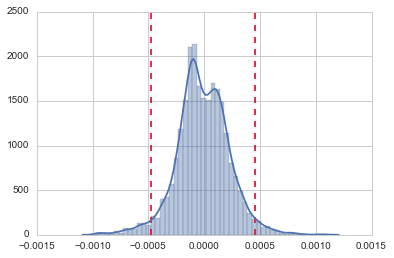

In [7]:
mean = coefficients.mean()
std = coefficients.std()
multiplier = 2
lower_cutoff = mean - multiplier * std
upper_cutoff = mean + multiplier * std

fig, ax = plt.subplots()
sns.distplot(coefficients)

# Add vertical lines
ymin, ymax = ax.get_ylim()
ax.vlines([lower_cutoff, upper_cutoff], ymin, ymax, linestyle='--', color='Crimson')

In [8]:
below_cutoff = coefficients[coefficients < lower_cutoff]
print(below_cutoff.shape)
below_cutoff.head()

(172,)


FPR1    -0.000507
FPR2    -0.000580
PRDX6   -0.000543
MYO1F   -0.000872
TNF     -0.000727
dtype: float64

How can we ***biologically*** assess what genes are found by our classifier? One way is through Gene Ontology enrichment

## Evaluating classifiers through Gene Ontology (GO) Enrichment

Gene ontology is a tree (aka directed acyclic graph or "dag") of gene annotations. The topmost node is the most general, and the bottommost nodes are the most specific. Here is an example GO graph.

![](figures/example_go_graph.png)

Three GO Domains:

* Cellular Component (CC)
* Molecular Function (MF)
* Biological Process (BP)

### Perform GO enrichment analysis (GOEA)


#### GOEA Step 1: Download GO graph file of "obo" type (same for all species)

This will download the file `"go-basic.obo"` if it doesn't already exist. This only needs to be done once.

In [9]:
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo()

# Show the filename
obo_fname

#Above is a DAG - directed acyclic graph
#builiding graph

  EXISTS: go-basic.obo


'go-basic.obo'

#### GOEA Step 2: Create the GO graph (same for all species)

(this may take some time to build the graph)

In [10]:
obo_dag = goatools.obo_parser.GODag(obo_file=obo_fname)

load obo file go-basic.obo


go-basic.obo: format-version(1.2) data-version(releases/2016-06-17)


46877 nodes imported


In [11]:
#Now built graph - same for all species and experiment.
#Next build map for our expt data

#### GOEA Step 3: Get gene ID to GO id mapping (species-specific and experiment-specific)

Here we are establishing the background for our GOEA. Defining your background is **very important** because, for example, there are lots of neural genes so if you use all human genes as background in your study of which genes are upregulated in Neuron Type X vs Neuron Type Y, you'll get a bunch of neuron genes (which is true) but not the smaller differences between X and Y. Typicall, you use *all expressed genes* as the background.

For our data, we can access all expressed genes very simply by getting the column names in the dataframe: `singles.columns`, which is the dataframe we used for classifying and shows *all expressed genes in single cells.* This will be our background.

In [12]:
# Initialize the "mygene.info" (http://mygene.info/) interface
mg = mygene.MyGeneInfo()

mygene_output = mg.querymany(singles.columns, ## V important - background is singles.columns
                             scopes='symbol', fields=['go.BP', 'go.MF', 'go.CC'], species='mouse', 
                             returnall=True)

gene_name_to_go = parse_mygene_output(mygene_output)

#Cool!!
#Background is important because you don't want to interpret signal in sample as novel
#e.g. lot of immune genes, lot of olfactory system - no doubt you will get immune genes in immune cells
#therefore background should be expressed genes in your system
#

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-6013...done.
Finished.
107 input query terms found dup hits:
	[('GM12657', 2), ('GM6788', 2), ('GM6548', 2), ('4930519F09RIK', 2), ('2410006H16RIK', 2), ('GM9104'
737 input query terms found no hit:
	['AK163153', 'AK036897', 'AK138383', 'AK164875', 'AK043564', 'AK134158', 'GM4769', '1110058L19RIK', 


#### GOEA Step 4: Create a GO enrichment calculator object `go_enricher` (species- and experiment-specific)

In this step, we are using the two objects we've created (`obo_dag` from Step 2 and `gene_name_to_go` from Step 3) plus the gene ids to create a `go_enricher` object

In [13]:
go_enricher = goatools.GOEnrichmentStudy(singles.columns, gene_name_to_go, obo_dag) 
###!!Propagate counts = True - all child genes also included in parent terms

Propagating term counts to parents ..


 5,203 out of  6,013 population items found in association


In [ ]:
#need obo_dag - combined terms parents could be significant
#more specific terms may not be
#oba_dag is the DAG of all relationships of GO terms / tree show above
#who are parents and who are children
#may need to go to grandfather to see significant p value if test set quite generic


#### GOEA Step 5: Calculate go enrichment!!! (species- and experiment-specific)

Now we are ready to run go enrichment!! Let's take our enriched genes of interest and run the enrichment analysis!

In [14]:
genes_of_interest = below_cutoff.index

# "results" is a list and is annoying to deal with ... 
# ... so we'll make a dataframe in the next step
results = go_enricher.run_study(genes_of_interest)

# Create a dataframe of the results so it's easier to deal with
below_cutoff_go_enrichment = pd.DataFrame([r.__dict__ for r in results])
print(below_cutoff_go_enrichment.shape)
below_cutoff_go_enrichment.head()

Calculating uncorrected p-values using fisher
   158 out of    172 study items found in association
Running multitest correction: local bonferroni
Running multitest correction: local sidak
Running multitest correction: local holm
15,129 GO terms are associated with 158 of 172 study items in a population of 6,013
(15129, 18)


,GO,NS,_methods,enrichment,goterm,name,p_bonferroni,p_holm,p_sidak,p_uncorrected,pop_count,pop_items,pop_n,ratio_in_pop,ratio_in_study,study_count,study_items,study_n
0,GO:0050715,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0050715\tlevel-05\tdepth-08\tpositive regul...,positive regulation of cytokine secretion,0.002848,0.002848,0.002776,1.882570e-07,42,"{CASP1, IL1B, FGR, LGALS9, XBP1, CD36, NCL, IL...",6013,"(42, 6013)","(12, 172)",12,"{CD84, CLEC4N, CSF1R, LGALS9, HSPD1, CD14, TLR...",172
1,GO:0070372,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0070372\tlevel-06\tdepth-09\tregulation of ...,regulation of ERK1 and ERK2 cascade,0.004209,0.004209,0.004103,2.782195e-07,79,"{RAP1B, RAPGEF2, CCL6, C5AR1, IL1B, CCR1, DAB2...",6013,"(79, 6013)","(13, 172)",13,"{PTPN6, CCL6, C5AR1, CCR1, CSF1R, DAB2, DYNLT1...",172
2,GO:0050727,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0050727\tlevel-04\tdepth-05\tregulation of ...,regulation of inflammatory response,0.004401,0.004400,0.004290,2.909038e-07,107,"{PIK3AP1, FCGR2B, CX3CL1, CCL4, RABGEF1, MGLL,...",6013,"(107, 6013)","(15, 172)",15,"{ACP5, IL1R2, CCL6, FCGR3, LGALS9, FCGR2B, HSP...",172
3,GO:0032760,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0032760\tlevel-06\tdepth-06\tpositive regul...,positive regulation of tumor necrosis factor p...,0.004571,0.004569,0.004455,3.021031e-07,44,"{PIK3R1, MYD88, LGALS9, ARHGEF2, CD36, NCL, CY...",6013,"(44, 6013)","(10, 172)",10,"{THBS1, CD84, FCGR3, LGALS9, HSPD1, CCL2, TLR2...",172
4,GO:0045087,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0045087\tlevel-03\tdepth-04\tinnate immune ...,innate immune response,0.004610,0.004608,0.004494,3.047053e-07,154,"{TEC, NLRC5, FGR, NFKB2, SLAMF7, ARHGEF2, POLR...",6013,"(154, 6013)","(19, 172)",19,"{CD84, PTPN6, IFITM3, IFNB1, OASL2, CLEC4N, CS...",172


Now we're going to ..... say it with me ...... **add a column!** that is the negative log10 of the p-value so it's easier to plot and deal with.

In [15]:
below_cutoff_go_enrichment['log10_p_bonferroni'] = -np.log10(below_cutoff_go_enrichment['p_bonferroni'])
#add col that contains log10_p_bonferroni values
print(below_cutoff_go_enrichment.shape)
below_cutoff_go_enrichment.head()

(15129, 19)


,GO,NS,_methods,enrichment,goterm,name,p_bonferroni,p_holm,p_sidak,p_uncorrected,pop_count,pop_items,pop_n,ratio_in_pop,ratio_in_study,study_count,study_items,study_n,log10_p_bonferroni
0,GO:0050715,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0050715\tlevel-05\tdepth-08\tpositive regul...,positive regulation of cytokine secretion,0.002848,0.002848,0.002776,1.882570e-07,42,"{CASP1, IL1B, FGR, LGALS9, XBP1, CD36, NCL, IL...",6013,"(42, 6013)","(12, 172)",12,"{CD84, CLEC4N, CSF1R, LGALS9, HSPD1, CD14, TLR...",172,2.545439
1,GO:0070372,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0070372\tlevel-06\tdepth-09\tregulation of ...,regulation of ERK1 and ERK2 cascade,0.004209,0.004209,0.004103,2.782195e-07,79,"{RAP1B, RAPGEF2, CCL6, C5AR1, IL1B, CCR1, DAB2...",6013,"(79, 6013)","(13, 172)",13,"{PTPN6, CCL6, C5AR1, CCR1, CSF1R, DAB2, DYNLT1...",172,2.375802
2,GO:0050727,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0050727\tlevel-04\tdepth-05\tregulation of ...,regulation of inflammatory response,0.004401,0.004400,0.004290,2.909038e-07,107,"{PIK3AP1, FCGR2B, CX3CL1, CCL4, RABGEF1, MGLL,...",6013,"(107, 6013)","(15, 172)",15,"{ACP5, IL1R2, CCL6, FCGR3, LGALS9, FCGR2B, HSP...",172,2.356440
3,GO:0032760,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0032760\tlevel-06\tdepth-06\tpositive regul...,positive regulation of tumor necrosis factor p...,0.004571,0.004569,0.004455,3.021031e-07,44,"{PIK3R1, MYD88, LGALS9, ARHGEF2, CD36, NCL, CY...",6013,"(44, 6013)","(10, 172)",10,"{THBS1, CD84, FCGR3, LGALS9, HSPD1, CCL2, TLR2...",172,2.340035
4,GO:0045087,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0045087\tlevel-03\tdepth-04\tinnate immune ...,innate immune response,0.004610,0.004608,0.004494,3.047053e-07,154,"{TEC, NLRC5, FGR, NFKB2, SLAMF7, ARHGEF2, POLR...",6013,"(154, 6013)","(19, 172)",19,"{CD84, PTPN6, IFITM3, IFNB1, OASL2, CLEC4N, CS...",172,2.336310


Let's make sure this dataframe is sorted in order of enrichment. By default, this is sorting in *ascending* order, and we want the most enriched to be at the top, so let's say `ascending=False`.

In [16]:
below_cutoff_go_enrichment = below_cutoff_go_enrichment.sort_values('log10_p_bonferroni', ascending=False)
#asc false as p 10e-10 more significant than p 10e-5
below_cutoff_go_enrichment = below_cutoff_go_enrichment.query('log10_p_bonferroni > 2')
print(below_cutoff_go_enrichment.shape)
below_cutoff_go_enrichment.head()
#use name col as y axis and log10 enrichment as x axis

(29, 19)


,GO,NS,_methods,enrichment,goterm,name,p_bonferroni,p_holm,p_sidak,p_uncorrected,pop_count,pop_items,pop_n,ratio_in_pop,ratio_in_study,study_count,study_items,study_n,log10_p_bonferroni
11797,GO:0005125,MF,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0005125\tlevel-04\tdepth-04\tcytokine activ...,cytokine activity,0.002517,0.002517,0.002453,1.663570e-07,52,"{GRN, TSLP, IFNB1, CXCL1, IL1B, CXCL10, IL27, ...",6013,"(52, 6013)","(11, 172)",11,"{IL1RN, GRN, IFNB1, CCL6, CXCL10, CXCL3, CCL2,...",172,2.599149
0,GO:0050715,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0050715\tlevel-05\tdepth-08\tpositive regul...,positive regulation of cytokine secretion,0.002848,0.002848,0.002776,1.882570e-07,42,"{CASP1, IL1B, FGR, LGALS9, XBP1, CD36, NCL, IL...",6013,"(42, 6013)","(12, 172)",12,"{CD84, CLEC4N, CSF1R, LGALS9, HSPD1, CD14, TLR...",172,2.545439
1,GO:0070372,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0070372\tlevel-06\tdepth-09\tregulation of ...,regulation of ERK1 and ERK2 cascade,0.004209,0.004209,0.004103,2.782195e-07,79,"{RAP1B, RAPGEF2, CCL6, C5AR1, IL1B, CCR1, DAB2...",6013,"(79, 6013)","(13, 172)",13,"{PTPN6, CCL6, C5AR1, CCR1, CSF1R, DAB2, DYNLT1...",172,2.375802
2,GO:0050727,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0050727\tlevel-04\tdepth-05\tregulation of ...,regulation of inflammatory response,0.004401,0.004400,0.004290,2.909038e-07,107,"{PIK3AP1, FCGR2B, CX3CL1, CCL4, RABGEF1, MGLL,...",6013,"(107, 6013)","(15, 172)",15,"{ACP5, IL1R2, CCL6, FCGR3, LGALS9, FCGR2B, HSP...",172,2.356440
3,GO:0032760,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0032760\tlevel-06\tdepth-06\tpositive regul...,positive regulation of tumor necrosis factor p...,0.004571,0.004569,0.004455,3.021031e-07,44,"{PIK3R1, MYD88, LGALS9, ARHGEF2, CD36, NCL, CY...",6013,"(44, 6013)","(10, 172)",10,"{THBS1, CD84, FCGR3, LGALS9, HSPD1, CCL2, TLR2...",172,2.340035


Let's look at the distribution of the log10 p-values

/Users/duncan/anaconda/envs/single-cell-bioinformatics/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


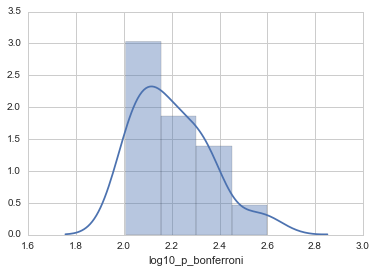

In [17]:
sns.distplot(below_cutoff_go_enrichment['log10_p_bonferroni'])

Now we can also plot this data! Let's just take a subset, say the first 10 and look at the distribution of p-values here.

(10, 19)


/Users/duncan/anaconda/envs/single-cell-bioinformatics/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


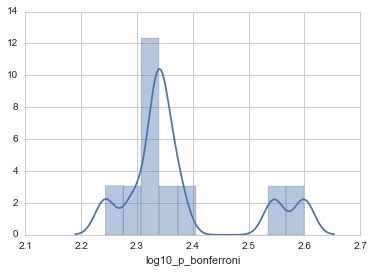

In [18]:
below_cutoff_go_enrichment_subset = below_cutoff_go_enrichment.iloc[:10, :]
print(below_cutoff_go_enrichment_subset.shape)
sns.distplot(below_cutoff_go_enrichment_subset['log10_p_bonferroni'])

Now let's plot the GO categories! We want to make sure they stay in the highest-lowest order by specifying "order" (otherwise they will be alphabetical!)

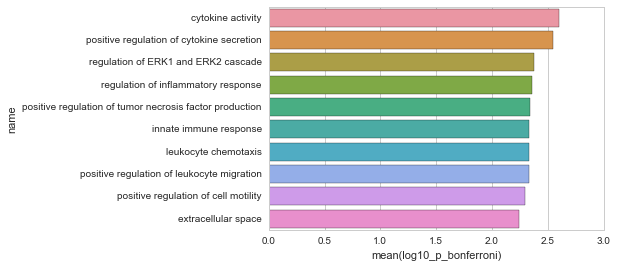

In [19]:
order = below_cutoff_go_enrichment_subset['name']

fig, ax = plt.subplots()
sns.barplot(x='log10_p_bonferroni', y='name', data=below_cutoff_go_enrichment_subset, orient='h', order=order)
fig.savefig("below_cutoff_go_enrichment.pdf")
#GO is performing a hypergeometric test which is equivalent to Fisher's exact test
#All Venn diagrams one set of all genes, one of GO term and all genes of interest and is
#calculating overlap of goi and GO term

### Exercise

1. Perform GO enrichment on the genes ABOVE the upper cutoff.
2. Plot the enrichment as a bar graph.
4. Try using only the LPS response genes for classification, and calculate GO enrichment on those, too. Do you have to change the background as well?

Use the cells below.

In [20]:
# Initialize the "mygene.info" (http://mygene.info/) interface
mg = mygene.MyGeneInfo()

mygene_output = mg.querymany(singles.columns, ## V important - background is singles.columns
                             scopes='symbol', fields=['go.BP', 'go.MF', 'go.CC'], species='mouse', 
                             returnall=True)

gene_name_to_go = parse_mygene_output(mygene_output)

#Cool!!
#Background is important because you don't want to interpret signal in sample as novel
#e.g. lot of immune genes, lot of olfactory system - no doubt you will get immune genes in immune cells
#therefore background should be expressed genes in your system
#

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-6013...done.
Finished.
107 input query terms found dup hits:
	[('GM12657', 2), ('GM6788', 2), ('GM6548', 2), ('4930519F09RIK', 2), ('2410006H16RIK', 2), ('GM9104'
737 input query terms found no hit:
	['AK163153', 'AK036897', 'AK138383', 'AK164875', 'AK043564', 'AK134158', 'GM4769', '1110058L19RIK', 


In [21]:
go_enricher = goatools.GOEnrichmentStudy(singles.columns, gene_name_to_go, obo_dag)

Propagating term counts to parents ..


 5,203 out of  6,013 population items found in association


In [22]:
# YOUR CODE HERE
above_cutoff = coefficients[coefficients > upper_cutoff] # if too many genes no enrichment cf packground
print(above_cutoff.shape)
above_cutoff.head()

(153,)


RABGAP1L    0.000636
H2-OA       0.000502
H2-AA       0.000576
H2-Q7       0.000586
STAP2       0.000658
dtype: float64

In [23]:
genes_of_interest = above_cutoff.index
genes_of_interest

Index(['RABGAP1L', 'H2-OA', 'H2-AA', 'H2-Q7', 'STAP2', 'ZEB1', 'AK041408',
       'PAIP2', 'NXF1', 'AW112010',
       ...
       'LRRC33', 'CD86', 'KTELC1', 'TMEM39A', 'SAMSN1', 'USP16', 'SYNJ1',
       'GCFC1', 'SLC5A3', 'MX1'],
      dtype='object', length=153)

In [24]:
# YOUR CODE HERE
results = go_enricher.run_study(genes_of_interest)

# Create a dataframe of the results so it's easier to deal with
above_cutoff_go_enrichment = pd.DataFrame([r.__dict__ for r in results])
print(above_cutoff_go_enrichment.shape)
above_cutoff_go_enrichment.head()

Calculating uncorrected p-values using fisher
   134 out of    153 study items found in association
Running multitest correction: local bonferroni
Running multitest correction: local sidak
Running multitest correction: local holm
15,129 GO terms are associated with 134 of 153 study items in a population of 6,013
(15129, 18)


,GO,NS,_methods,enrichment,goterm,name,p_bonferroni,p_holm,p_sidak,p_uncorrected,pop_count,pop_items,pop_n,ratio_in_pop,ratio_in_study,study_count,study_items,study_n
0,GO:0002682,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0002682\tlevel-02\tdepth-02\tregulation of ...,regulation of immune system process,0.024383,0.024383,0.023769,0.000002,468,"{PNP, SLFN1, CLEC2G, HCST, BST1, POLR3C, WHSC1...",6013,"(468, 6013)","(30, 153)",30,"{TEC, CACNB3, H2-OA, KLRK1, JAG1, CD86, PCBP2,...",153
1,GO:0050789,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0050789\tlevel-01\tdepth-01\tregulation of ...,regulation of biological process,0.118122,0.118106,0.115144,0.000008,2886,"{HK1, QARS, SNF8, UBN1, RNF146, HCST, UTP11L, ...",6013,"(2886, 6013)","(101, 153)",101,"{TEC, CKS1B, USE1, NOSTRIN, CACNB3, AKAP9, IL1...",153
2,GO:1902105,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:1902105\tlevel-04\tdepth-05\tregulation of ...,regulation of leukocyte differentiation,0.156089,0.156059,0.152154,0.000010,121,"{PNP, MITF, ATP11C, CLEC2G, NFKBID, AP3B1, CCR...",6013,"(121, 6013)","(13, 153)",13,"{ADAM8, TMEM176B, CCR7, ZEB1, RASSF2, H2-OA, I...",153
3,GO:0065007,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0065007\tlevel-01\tdepth-01\tbiological reg...,biological regulation,0.261733,0.261647,0.255134,0.000017,3011,"{HK1, QARS, SNF8, UBN1, RNF146, HCST, UTP11L, ...",6013,"(3011, 6013)","(103, 153)",103,"{TEC, CKS1B, USE1, NOSTRIN, CACNB3, AKAP9, IL1...",153
4,GO:0002376,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0002376\tlevel-01\tdepth-01\timmune system ...,immune system process,0.368721,0.368575,0.359425,0.000024,507,"{ARHGEF2, PFDN1, POLR3C, IFIT1, SKAP2, IPO7, F...",6013,"(507, 6013)","(29, 153)",29,"{TEC, PROCR, H2-Q7, TNFRSF9, PDE4D, CACNB3, H2...",153


In [25]:
# YOUR CODE HERE
above_cutoff_go_enrichment['log10_p_bonferroni'] = -np.log10(above_cutoff_go_enrichment['p_bonferroni'])
#add col that contains log10_p_bonferroni values
print(above_cutoff_go_enrichment.shape)
above_cutoff_go_enrichment.head()

(15129, 19)


,GO,NS,_methods,enrichment,goterm,name,p_bonferroni,p_holm,p_sidak,p_uncorrected,pop_count,pop_items,pop_n,ratio_in_pop,ratio_in_study,study_count,study_items,study_n,log10_p_bonferroni
0,GO:0002682,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0002682\tlevel-02\tdepth-02\tregulation of ...,regulation of immune system process,0.024383,0.024383,0.023769,0.000002,468,"{PNP, SLFN1, CLEC2G, HCST, BST1, POLR3C, WHSC1...",6013,"(468, 6013)","(30, 153)",30,"{TEC, CACNB3, H2-OA, KLRK1, JAG1, CD86, PCBP2,...",153,1.612906
1,GO:0050789,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0050789\tlevel-01\tdepth-01\tregulation of ...,regulation of biological process,0.118122,0.118106,0.115144,0.000008,2886,"{HK1, QARS, SNF8, UBN1, RNF146, HCST, UTP11L, ...",6013,"(2886, 6013)","(101, 153)",101,"{TEC, CKS1B, USE1, NOSTRIN, CACNB3, AKAP9, IL1...",153,0.927669
2,GO:1902105,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:1902105\tlevel-04\tdepth-05\tregulation of ...,regulation of leukocyte differentiation,0.156089,0.156059,0.152154,0.000010,121,"{PNP, MITF, ATP11C, CLEC2G, NFKBID, AP3B1, CCR...",6013,"(121, 6013)","(13, 153)",13,"{ADAM8, TMEM176B, CCR7, ZEB1, RASSF2, H2-OA, I...",153,0.806626
3,GO:0065007,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0065007\tlevel-01\tdepth-01\tbiological reg...,biological regulation,0.261733,0.261647,0.255134,0.000017,3011,"{HK1, QARS, SNF8, UBN1, RNF146, HCST, UTP11L, ...",6013,"(3011, 6013)","(103, 153)",103,"{TEC, CKS1B, USE1, NOSTRIN, CACNB3, AKAP9, IL1...",153,0.582141
4,GO:0002376,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0002376\tlevel-01\tdepth-01\timmune system ...,immune system process,0.368721,0.368575,0.359425,0.000024,507,"{ARHGEF2, PFDN1, POLR3C, IFIT1, SKAP2, IPO7, F...",6013,"(507, 6013)","(29, 153)",29,"{TEC, PROCR, H2-Q7, TNFRSF9, PDE4D, CACNB3, H2...",153,0.433302


In [26]:
above_cutoff_go_enrichment = above_cutoff_go_enrichment.sort_values('log10_p_bonferroni', ascending=False) #largest log transform first = smallest p values
#asc false as p 10e-10 more significant than p 10e-5
print(above_cutoff_go_enrichment.shape)
above_cutoff_go_enrichment.head()
#use name col as y axis and log10 enrichment as x axis

(15129, 19)


,GO,NS,_methods,enrichment,goterm,name,p_bonferroni,p_holm,p_sidak,p_uncorrected,pop_count,pop_items,pop_n,ratio_in_pop,ratio_in_study,study_count,study_items,study_n,log10_p_bonferroni
0,GO:0002682,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0002682\tlevel-02\tdepth-02\tregulation of ...,regulation of immune system process,0.024383,0.024383,0.023769,0.000002,468,"{PNP, SLFN1, CLEC2G, HCST, BST1, POLR3C, WHSC1...",6013,"(468, 6013)","(30, 153)",30,"{TEC, CACNB3, H2-OA, KLRK1, JAG1, CD86, PCBP2,...",153,1.612906
10410,GO:0044459,CC,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0044459\tlevel-02\tdepth-02\tplasma membran...,plasma membrane part,0.042632,0.042629,0.041557,0.000003,526,"{HK1, CTTN, RAPGEF2, RDH11, ARHGEF2, MAPK8IP3,...",6013,"(526, 6013)","(33, 153)",33,"{TEC, H2-Q7, TNFRSF9, PDE4D, CACNB3, H2-OA, KL...",153,1.370262
1,GO:0050789,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0050789\tlevel-01\tdepth-01\tregulation of ...,regulation of biological process,0.118122,0.118106,0.115144,0.000008,2886,"{HK1, QARS, SNF8, UBN1, RNF146, HCST, UTP11L, ...",6013,"(2886, 6013)","(101, 153)",101,"{TEC, CKS1B, USE1, NOSTRIN, CACNB3, AKAP9, IL1...",153,0.927669
2,GO:1902105,BP,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:1902105\tlevel-04\tdepth-05\tregulation of ...,regulation of leukocyte differentiation,0.156089,0.156059,0.152154,0.000010,121,"{PNP, MITF, ATP11C, CLEC2G, NFKBID, AP3B1, CCR...",6013,"(121, 6013)","(13, 153)",13,"{ADAM8, TMEM176B, CCR7, ZEB1, RASSF2, H2-OA, I...",153,0.806626
10411,GO:0005891,CC,"[(local, bonferroni, bonferroni), (local, sida...",e,GO:0005891\tlevel-04\tdepth-08\tvoltage-gated ...,voltage-gated calcium channel complex,0.244492,0.244428,0.238328,0.000016,3,"{CACNB3, PDE4B, PDE4D}",6013,"(3, 6013)","(3, 153)",3,"{CACNB3, PDE4B, PDE4D}",153,0.611735


/Users/duncan/anaconda/envs/single-cell-bioinformatics/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


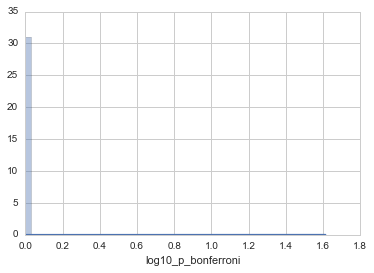

In [27]:
sns.distplot(above_cutoff_go_enrichment['log10_p_bonferroni'])

(15129, 19)


/Users/duncan/anaconda/envs/single-cell-bioinformatics/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


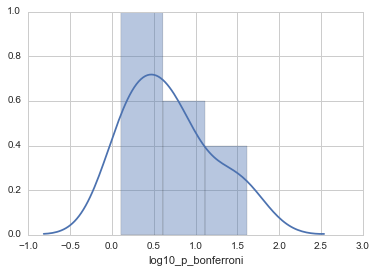

In [29]:
above_cutoff_go_enrichment_subset = above_cutoff_go_enrichment.iloc[:10, :]
# above_cutoff_go_enrichment_subset = above_cutoff_go_enrichment.query('log10_p_bonferroni > 2')
print(above_cutoff_go_enrichment.shape)
sns.distplot(above_cutoff_go_enrichment_subset['log10_p_bonferroni'])

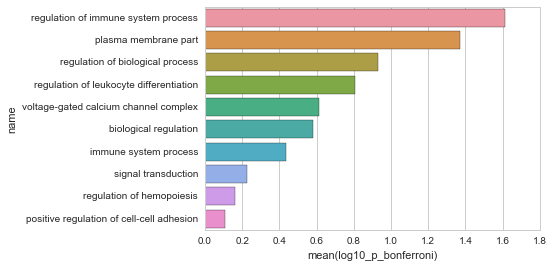

In [30]:
order = above_cutoff_go_enrichment_subset['name']

fig, ax = plt.subplots()
sns.barplot(x='log10_p_bonferroni', y='name', data=above_cutoff_go_enrichment_subset, orient='h', order=order)
fig.savefig("above_cutoff_go_enrichment.pdf")
#GO is performing a hypergeometric test which is equivalent to Fisher's exact test
#All Venn diagrams one set of all genes, one of GO term and all genes of interest and is
#calculating overlap of goi and GO term

In [31]:
subset = expression_feature.query('gene_category == "LPS Response"')
subset.head(5)

,gene_category
1110018G07RIK,LPS Response
1110032F04RIK,LPS Response
1110038F14RIK,LPS Response
1190002H23RIK,LPS Response
1200009I06RIK,LPS Response


In [32]:
lps_response_genes = subset.index #row names = genes, columns = samples / features
lps_response_genes
#expression feature data
#this times genes are samples
#and rows features
#e.g. whether TF
#e.g. whether LPS response

Index(['1110018G07RIK', '1110032F04RIK', '1110038F14RIK', '1190002H23RIK',
       '1200009I06RIK', '1600014C10RIK', '1810029B16RIK', '2010002M12RIK',
       '2200002D01RIK', '2210009G21RIK',
       ...
       'ZCCHC2', 'ZCCHC6', 'ZDHHC21', 'ZFP36', 'ZFP558', 'ZFP800', 'ZFP811',
       'ZHX2', 'ZNFX1', 'ZUFSP'],
      dtype='object', length=945)

In [33]:
singles_ids = [x for x in expression.index if x.startswith('S')]
singles = expression.loc[singles_ids]
singles.shape

(18, 6312)

In [34]:
singles = singles.loc[:, (singles > 1).sum() >= 3]
print(singles.shape)
singles.tail()
# expression.tail()

(18, 6013)


,NPL,QK,AK163153,AGPAT4,IGF2R,MRPL18,TCP1,RNASEL,ACAT2,WTAP,...,MIR692-1,RSPH3B,TAGAP1,RNASET2A,RPS6KA2,DHX9,RNASET2B,FGFR1OP,BRP44L,SFT2D1
S14,0.099121,2.294456,1.110511,4.430612,0.703213,5.805900,5.127292,4.373110,4.634034,2.364453,...,3.708960,2.816471,0.353337,3.171981,0.598556,2.634747,4.574811,4.060312,7.261360,0.946980
S15,0.100920,0.301120,1.202271,0.000000,0.000000,0.280902,6.703530,0.000000,0.131139,0.120001,...,4.338427,0.000000,0.000000,1.249966,4.866136,0.203168,3.606193,3.981172,6.776869,0.000000
S16,0.206361,3.547688,4.446612,0.000000,0.599134,4.636011,4.934580,0.000000,0.072570,0.540513,...,3.304521,2.184800,0.338401,1.352671,3.314155,3.511727,3.200499,0.000000,4.288363,0.146869
S17,0.104884,2.185832,1.367261,4.219120,0.163095,0.156241,5.317671,0.000000,0.000000,0.507563,...,3.618070,2.465683,0.097507,0.747714,0.088512,0.579376,0.000000,0.000000,6.877628,5.181148
S18,0.000000,0.040923,0.428320,0.171028,2.456613,4.820447,4.619659,4.334508,0.107746,0.682873,...,2.627022,1.101847,0.094660,3.751406,1.075959,1.809603,1.431793,0.000000,6.542975,1.800422


In [35]:
singles_maturity = metadata.loc[singles.index, 'maturity']
singles_maturity

S1     immature
S2     immature
S3     immature
S4     immature
S5     immature
S6     immature
S7     immature
S8     immature
S9     immature
S10    immature
S11    immature
S12      mature
S13      mature
S14    immature
S15    immature
S16      mature
S17    immature
S18    immature
Name: maturity, dtype: object

In [36]:
singles_lps_response = singles.loc[:,lps_response_genes]
print(singles_lps_response.shape)
singles_lps_response.head(20)

(18, 945)


,1110018G07RIK,1110032F04RIK,1110038F14RIK,1190002H23RIK,1200009I06RIK,1600014C10RIK,1810029B16RIK,2010002M12RIK,2200002D01RIK,2210009G21RIK,...,ZCCHC2,ZCCHC6,ZDHHC21,ZFP36,ZFP558,ZFP800,ZFP811,ZHX2,ZNFX1,ZUFSP
S1,3.711442,NaN,0.000000,NaN,3.275468,0.000000,5.609305,NaN,NaN,0.000000,...,0.035344,3.042277,4.425735,4.092559,NaN,4.025124,NaN,0.779382,2.998800,0.000000
S2,4.361671,NaN,0.147643,NaN,0.000000,0.000000,5.478071,NaN,NaN,0.000000,...,2.251330,1.018315,4.955713,0.356008,NaN,4.297776,NaN,0.032569,3.091207,5.000843
S3,0.000000,NaN,3.737014,NaN,2.987093,0.063526,5.320993,NaN,NaN,0.000000,...,0.094925,0.126673,3.952273,1.956983,NaN,0.000000,NaN,0.000000,3.794063,2.928699
S4,2.719587,NaN,0.000000,NaN,0.045823,0.000000,0.488049,NaN,NaN,0.000000,...,0.137427,2.025546,4.193989,2.372572,NaN,0.121924,NaN,0.000000,0.230278,0.430168
S5,2.982073,NaN,0.000000,NaN,2.829152,0.000000,5.093188,NaN,NaN,0.000000,...,0.616401,0.000000,4.039816,0.000000,NaN,4.714087,NaN,1.565475,0.860254,4.866979
S6,0.000000,NaN,0.851146,NaN,1.016506,3.500878,6.097377,NaN,NaN,0.721829,...,3.635734,3.437551,3.687978,1.033553,NaN,3.110635,NaN,2.192246,3.108098,2.597904
S7,3.881965,NaN,1.628513,NaN,2.743949,0.000000,5.956346,NaN,NaN,0.000000,...,0.025485,0.000000,3.730004,3.654413,NaN,1.278290,NaN,0.000000,1.197472,2.694247
S8,3.034992,NaN,0.000000,NaN,3.948293,4.506814,7.140110,NaN,NaN,0.242281,...,0.526813,3.475191,4.001580,6.502297,NaN,0.179204,NaN,0.000000,2.762293,0.412426
S9,0.031110,NaN,4.911391,NaN,0.000000,0.000000,6.510856,NaN,NaN,4.080961,...,0.059599,0.471974,4.701420,5.403925,NaN,3.443843,NaN,0.000000,3.096213,0.231651
S10,0.000000,NaN,3.882599,NaN,3.372394,0.000000,6.745099,NaN,NaN,0.000000,...,0.843348,1.035731,4.664242,0.141537,NaN,5.477474,NaN,0.136784,0.017415,0.000000


In [37]:
singles_lps_response.dropna()

,1110018G07RIK,1110032F04RIK,1110038F14RIK,1190002H23RIK,1200009I06RIK,1600014C10RIK,1810029B16RIK,2010002M12RIK,2200002D01RIK,2210009G21RIK,...,ZCCHC2,ZCCHC6,ZDHHC21,ZFP36,ZFP558,ZFP800,ZFP811,ZHX2,ZNFX1,ZUFSP


In [38]:
singles_lps_response_no_na = singles_lps_response.dropna(axis=1)
print(singles_lps_response_no_na.shape)
singles_lps_response_no_na.head()

(18, 616)


,1110018G07RIK,1110038F14RIK,1200009I06RIK,1600014C10RIK,1810029B16RIK,2210009G21RIK,2810474O19RIK,3110001I22RIK,4921513D23RIK,4930523C07RIK,...,ZC3H12C,ZC3HAV1,ZCCHC2,ZCCHC6,ZDHHC21,ZFP36,ZFP800,ZHX2,ZNFX1,ZUFSP
S1,3.711442,0.000000,3.275468,0.000000,5.609305,0.0,0.000000,3.828860,1.314573,3.778275,...,3.972904,3.509979,0.035344,3.042277,4.425735,4.092559,4.025124,0.779382,2.998800,0.000000
S2,4.361671,0.147643,0.000000,0.000000,5.478071,0.0,3.407342,0.000000,1.531443,0.000000,...,4.794306,4.984262,2.251330,1.018315,4.955713,0.356008,4.297776,0.032569,3.091207,5.000843
S3,0.000000,3.737014,2.987093,0.063526,5.320993,0.0,3.372359,0.058163,1.105115,0.025043,...,4.882749,0.807258,0.094925,0.126673,3.952273,1.956983,0.000000,0.000000,3.794063,2.928699
S4,2.719587,0.000000,0.045823,0.000000,0.488049,0.0,5.127847,0.000000,2.303969,0.000000,...,4.833354,4.538699,0.137427,2.025546,4.193989,2.372572,0.121924,0.000000,0.230278,0.430168
S5,2.982073,0.000000,2.829152,0.000000,5.093188,0.0,0.065122,4.635671,1.015640,0.461296,...,4.446634,0.157178,0.616401,0.000000,4.039816,0.000000,4.714087,1.565475,0.860254,4.866979


In [39]:
singles_subset = singles_lps_response_no_na

In [40]:
# Initialize the "mygene.info" (http://mygene.info/) interface
mg = mygene.MyGeneInfo()

mygene_output = mg.querymany(singles_subset.columns, ## V important - background is singles.columns
                             scopes='symbol', fields=['go.BP', 'go.MF', 'go.CC'], species='mouse', 
                             returnall=True)

gene_name_to_go = parse_mygene_output(mygene_output)

#Cool!!
#Background is important because you don't want to interpret signal in sample as novel
#e.g. lot of immune genes, lot of olfactory system - no doubt you will get immune genes in immune cells
#therefore background should be expressed genes in your system
#

querying 1-616...done.
Finished.
13 input query terms found dup hits:
	[('GM7609', 2), ('A630072M18RIK', 2), ('GM8979', 2), ('GBP6', 2), ('GM6548', 2), ('BAMBI-PS1', 2), (
62 input query terms found no hit:
	['1110018G07RIK', '1200009I06RIK', '1810029B16RIK', '2210009G21RIK', '4921513D23RIK', '6330409N04RIK


In [41]:
go_enricher = goatools.GOEnrichmentStudy(singles_subset.columns, gene_name_to_go, obo_dag)

Propagating term counts to parents ..


   543 out of    616 population items found in association


In [44]:
singles_subset.columns

Index(['1110018G07RIK', '1110038F14RIK', '1200009I06RIK', '1600014C10RIK',
       '1810029B16RIK', '2210009G21RIK', '2810474O19RIK', '3110001I22RIK',
       '4921513D23RIK', '4930523C07RIK',
       ...
       'ZC3H12C', 'ZC3HAV1', 'ZCCHC2', 'ZCCHC6', 'ZDHHC21', 'ZFP36', 'ZFP800',
       'ZHX2', 'ZNFX1', 'ZUFSP'],
      dtype='object', length=616)

In [46]:
singles_subset_maturity = metadata.loc[singles_subset.index, 'maturity']
subset_target = encoder.fit_transform(singles_subset_maturity)

In [47]:
classifier.fit(singles_subset, subset_target)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [48]:
coefficients = pd.Series(classifier.coef_.flat, index=singles_subset.columns)
coefficients.head()

/Users/duncan/anaconda/envs/single-cell-bioinformatics/lib/python3.5/site-packages/pandas/types/dtypes.py:127: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if string == 'category':


1110018G07RIK    0.000399
1110038F14RIK   -0.001395
1200009I06RIK    0.004301
1600014C10RIK    0.002402
1810029B16RIK   -0.001964
dtype: float64

/Users/duncan/anaconda/envs/single-cell-bioinformatics/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


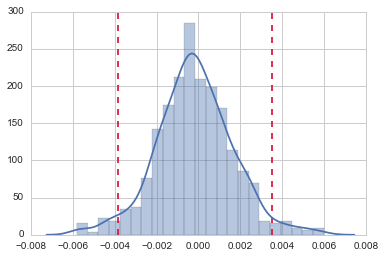

In [49]:
mean = coefficients.mean()
std = coefficients.std()
multiplier = 2
lower_cutoff = mean - multiplier * std
upper_cutoff = mean + multiplier * std

fig, ax = plt.subplots()
sns.distplot(coefficients)

# Add vertical lines
ymin, ymax = ax.get_ylim()
ax.vlines([lower_cutoff, upper_cutoff], ymin, ymax, linestyle='--', color='Crimson')

In [43]:
genes_of_interest = below_cutoff.index

# "results" is a list and is annoying to deal with ... 
# ... so we'll make a dataframe in the next step
results = go_enricher.run_study(genes_of_interest)

# Create a dataframe of the results so it's easier to deal with
below_cutoff_go_enrichment = pd.DataFrame([r.__dict__ for r in results])
print(below_cutoff_go_enrichment.shape)
below_cutoff_go_enrichment.head()

Calculating uncorrected p-values using fisher
    34 out of    172 study items found in association
Running multitest correction: local bonferroni
Running multitest correction: local sidak
Running multitest correction: local holm
6,810 GO terms are associated with 34 of 172 study items in a population of 616
(6810, 18)


,GO,NS,_methods,enrichment,goterm,name,p_bonferroni,p_holm,p_sidak,p_uncorrected,pop_count,pop_items,pop_n,ratio_in_pop,ratio_in_study,study_count,study_items,study_n
0,GO:0090304,BP,"[(local, bonferroni, bonferroni), (local, sida...",p,GO:0090304\tlevel-04\tdepth-05\tnucleic acid m...,nucleic acid metabolic process,0.005304,0.005303,0.005170,7.788640e-07,80,"{PAPD7, EREG, ETS2, IRF9, MITF, PCGF5, TRIM30A...",616,"(80, 616)","(4, 172)",4,"{ZFP800, REL, MITF, BATF}",172
1,GO:0036211,BP,"[(local, bonferroni, bonferroni), (local, sida...",p,GO:0036211\tlevel-04\tdepth-05\tprotein modifi...,protein modification process,0.005304,0.005303,0.005170,7.788640e-07,80,"{ST3GAL5, TLK2, MYD88, IL1B, PPP1R15B, TRIM30A...",616,"(80, 616)","(2, 172)",2,"{MDM2, TNF}",172
2,GO:0006464,BP,"[(local, bonferroni, bonferroni), (local, sida...",p,GO:0006464\tlevel-05\tdepth-06\tcellular prote...,cellular protein modification process,0.005304,0.005303,0.005170,7.788640e-07,80,"{ST3GAL5, TLK2, MYD88, IL1B, PPP1R15B, TRIM30A...",616,"(80, 616)","(2, 172)",2,"{MDM2, TNF}",172
3,GO:0006996,BP,"[(local, bonferroni, bonferroni), (local, sida...",p,GO:0006996\tlevel-03\tdepth-03\torganelle orga...,organelle organization,0.007377,0.007367,0.007191,1.083199e-06,60,"{DNAJC13, BCL2A1B, LNP, PAPD7, EREG, PALLD, PN...",616,"(60, 616)","(2, 172)",2,"{CCL2, TNF}",172
4,GO:1901360,BP,"[(local, bonferroni, bonferroni), (local, sida...",p,GO:1901360\tlevel-03\tdepth-03\torganic cyclic...,organic cyclic compound metabolic process,0.007836,0.007823,0.007639,1.150680e-06,105,"{PNP, ETS2, IRF9, MITF, CCDC86, NFKB2, STAT2, ...",616,"(105, 616)","(6, 172)",6,"{ZFP800, MITF, OASL2, UPP1, REL, BATF}",172
